# Data & Information quality assignment

TODO:
- perform data quality assesment using the following metrics:
    - completeness
- perform data imputation
- perform data quality assessment again:
    - completeness
    - accuracy
    
- perform ML quality analysis

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import utility.dirty_completeness as dirty_completeness
import utility.utility as utility  

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

SEED = 122
plt.style.use('fivethirtyeight')

In [ ]:
def build_heatmap(model, X, y):
    """
    This method generates an heatmap used by seaborn to create a confusion matrix.
    :param model: model for which the method computes the confusion matrix.
    :param validation_generator: dataset object over which the model computes its predictions.
    :param ensemble: Optional argument. If ensemble is True, it computes the confusion matrix using
    a selfe-ensemble method with 5 voters.
    :return pd.DataFrame object containing the confusion matrix.
    """
    y_predicted = model.predict(X)
    y_predicted = np.argmax(y_predicted, axis=1)

    y_test_labels = tf.argmax(y, axis=1)
    
    confusion_matrix = confusion_matrix(
        y_test_labels, 
        y_predicted,
    )
    c = []
    for item in confusion_matrix:
        c.append(np.around(item / np.sum(item), decimals=3))
    df_heatmap = pd.DataFrame(c)
    return df_heatmap

In [ ]:
def compute_report(model, test):
  """
  Compute recall, precision and f1-score for each class, for a model predicting
  on a given set.
  :param model: model to evaluate
  :param test: test set over which this method evaluate the input model.
  :return a pandas dataframe containing precision, recall and f1-score of the model.
  """

  # compute predictions
  y_pred = model.predict(test)
  y_pred = tf.argmax(y_pred, axis=1)

  # get true labels
  y_true = np.concatenate([y for x, y in test], axis=0)
  y_true = tf.argmax(y_true, axis=1)

  # return report  
  report = classification_report(y_true,
                                 y_pred,
                                 target_names=['n', 'p', 't'],
                                 output_dict=True)
  
  report = pd.DataFrame(report)
  report = report.drop(['accuracy',	'macro avg',	'weighted avg'], axis=1)
  return report

In [2]:
soybean_df = pd.read_csv('../datasets/soybean.csv')
soybean_df.head()

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,sclerotia,fruit-pods,fruit-spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots,class
0,october,normal,gt-norm,norm,yes,same-lst-yr,low-areas,pot-severe,none,90-100,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
1,august,normal,gt-norm,norm,yes,same-lst-two-yrs,scattered,severe,fungicide,80-89,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
2,july,normal,gt-norm,norm,yes,same-lst-yr,scattered,severe,fungicide,lt-80,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
3,july,normal,gt-norm,norm,yes,same-lst-yr,scattered,severe,none,80-89,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
4,october,normal,gt-norm,norm,yes,same-lst-two-yrs,scattered,pot-severe,none,lt-80,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker


Exploratory analysis.

In [3]:
soybean_df.nunique()

date                7
plant-stand         2
precip              3
temp                3
hail                2
crop-hist           4
area-damaged        4
severity            3
seed-tmt            3
germination         3
plant-growth        2
leaves              2
leafspots-halo      3
leafspots-marg      3
leafspot-size       3
leaf-spread         2
leaf-malf           2
leaf-mild           3
stem                2
lodging             2
stem-cankers        4
canker-lesion       4
fruiting-bodies     2
external-decay      2
mycelium            2
int-discolor        3
sclerotia           2
fruit-pods          3
fruit-spots         4
seed                2
mold-growth         2
seed-discolor       2
seed-size           2
shriveling          2
roots               3
class              15
dtype: int64

From the [Dataset documentation](https://archive.ics.uci.edu/ml/datasets/Soybean+(Large)) we can look at the values each variable can take. We can deduce that almost all the variables are categorical.\
Features that are not categorical are:

cyclic features:
- date

ordinal features:
- plant-stand
- precip
- temp
- germination


## Injection of null values.

In [4]:
df_s = dirty_completeness.injection(soybean_df, SEED, name='', name_class='class')

saved -completeness50%
saved -completeness60%
saved -completeness70%
saved -completeness80%
saved -completeness90%


## Data quality assesment before the imputation.

In this section, first we make a data quality assesment.

In [9]:
completeness_degree = [1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) for df in df_s]
completeness_degree

[0.5119366354306114,
 0.6105533244087461,
 0.7038152610441767,
 0.8046630968317715,
 0.9043953592146363]

## Basic imputation method.

Since there are a lot of categorical features, we believe a good basic imputation method could be to fill each NaN value with the mode of its belonging column.

In [10]:
imputed_df_s = []

for n, df in enumerate(df_s):
    simple_imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
    imputed_df = simple_imputer.fit_transform(df)
    imputed_df = pd.DataFrame(imputed_df, columns=df.columns)
    imputed_df_s.append(imputed_df)


## Data quality assesment after the data imputation.

First, we check that the completeness is 1 for each dataframe, after the imputation.

In [12]:
completeness_degree = [1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) for df in imputed_df_s]
print(f"The completeness degree for each impute dataframe is {completeness_degree}")

The completeness degree for each impute dataframe is [1.0, 1.0, 1.0, 1.0, 1.0]


Now, we compute the accuracy. First we mesure it using the exact matching.

In [27]:
utility.accuracy_assesment(imputed_df_s, soybean_df)

[0.858433734939759,
 0.8866577420794288,
 0.9132083891120035,
 0.9424364123159303,
 0.9721106648817492]

For the accuracy assesment based on the distance, we can convert the ordinal and cyclic variables to numerical values and mesure the accuracy bases on the distance between their values.


Date is cyclic variable, thus, we can transform it using a sinusoidal transformation with frequency equal to 12 (date represents months).


$x = to\_ordinal(date)$


$y = sin(\frac{1}{12}x)$

From the [Dataset documentation](https://archive.ics.uci.edu/ml/datasets/Soybean+(Large)), the following ordinal features have the domain in the table:
- plant-stand
- precip
- temp
- germination
- severity

| features | original domain | ordinal domain |
| --- | --- | --- |
|plant-stand|lt-norm, norm, gt-norm|0, 1, 2|
|precip|lt-norm, norm, gt-norm|0, 1, 2|
|temp|lt-norm, norm, gt-norm|0, 1, 2|
|germination|lt-80%, 80-89%, 90-100%|0, 1, 2|
|severity|minor, pot-severe, severe|0, 1, 2|


## Transformation of date in cyclic variable.

In [28]:
soybean_df['date'].unique()

array(['october', 'august', 'july', 'september', 'may', 'april', 'june'],
      dtype=object)

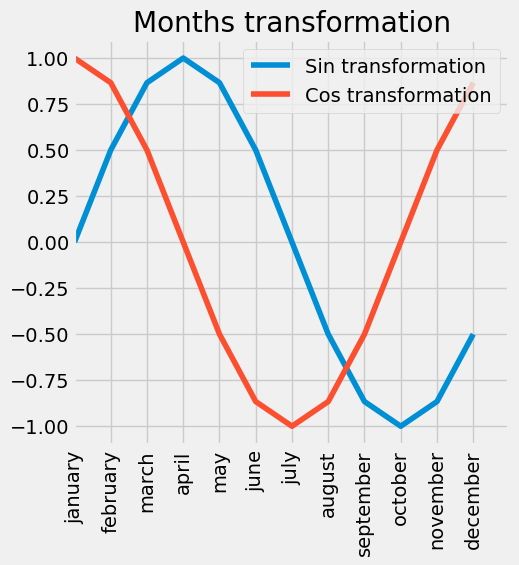

In [65]:
months = ['january',
          'february',
          'march',
          'april',
          'may',
          'june',
          'july',
          'august',
          'september', 
          'october',
          'november',
          'december']

period = 12
months_sin = [np.sin((2 * np.pi * i) / period) for i, _ in enumerate(months)]
months_cos = [np.cos((2 * np.pi * i) / period) for i, _ in enumerate(months)]

plt.figure(figsize=(5, 5))

plt.plot([i for i in range(len(months))], months_sin, label='Sin transformation')
plt.plot([i for i in range(len(months))], months_cos, label='Cos transformation')

plt.title('Months transformation')
plt.xticks([i for i in range(len(months))], months, rotation=90)
plt.xlim((0, 12))
plt.legend()

plt.show()

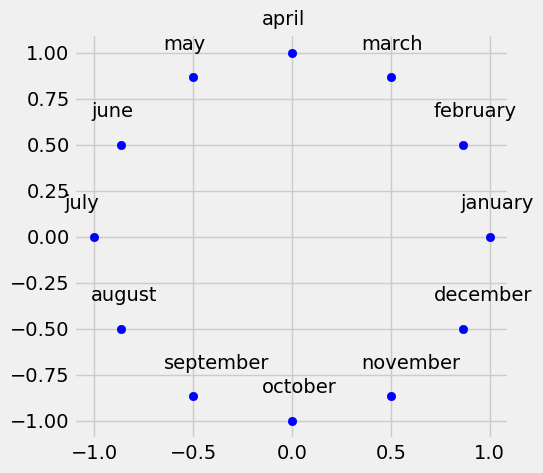

In [69]:
plt.figure(figsize=(5, 5))
for c, s, month in zip(months_cos, months_sin, months):
    plt.scatter(c, s, color='blue')
    plt.text(c-0.15,s+0.15,s=month)
    
plt.show()

Here we add a new column, month_cos_sin, which contain a tuple (cos, sin) corresponding to the month. This column is used for the accuracy assesment.

In [80]:
months_dict = {}

for c, s, m in zip(months_cos, months_sin, months):
    months_dict[m] = (c, s)

numeric_soybean = soybean_df.copy()
    
numeric_soybean['month_cos_sin'] = soybean_df.apply(lambda row: (months_dict[row['date']][0], months_dict[row['date']][1]), axis=1)
numeric_soybean.drop(columns=['date'])
numeric_soybean

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,seed,mold-growth,seed-discolor,seed-size,shriveling,roots,class,month_cos_sin,month_sin,month_cos
0,october,normal,gt-norm,norm,yes,same-lst-yr,low-areas,pot-severe,none,90-100,...,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker,"(-1.8369701987210297e-16, -1.0)",-1.000000e+00,-1.836970e-16
1,august,normal,gt-norm,norm,yes,same-lst-two-yrs,scattered,severe,fungicide,80-89,...,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker,"(-0.8660254037844388, -0.4999999999999997)",-5.000000e-01,-8.660254e-01
2,july,normal,gt-norm,norm,yes,same-lst-yr,scattered,severe,fungicide,lt-80,...,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker,"(-1.0, 1.2246467991473532e-16)",1.224647e-16,-1.000000e+00
3,july,normal,gt-norm,norm,yes,same-lst-yr,scattered,severe,none,80-89,...,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker,"(-1.0, 1.2246467991473532e-16)",1.224647e-16,-1.000000e+00
4,october,normal,gt-norm,norm,yes,same-lst-two-yrs,scattered,pot-severe,none,lt-80,...,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker,"(-1.8369701987210297e-16, -1.0)",-1.000000e+00,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,september,normal,gt-norm,gt-norm,yes,same-lst-two-yrs,low-areas,minor,fungicide,80-89,...,norm,absent,absent,norm,absent,norm,frog-eye-leaf-spot,"(-0.5000000000000004, -0.8660254037844385)",-8.660254e-01,-5.000000e-01
245,september,normal,gt-norm,norm,yes,same-lst-sev-yrs,scattered,pot-severe,none,90-100,...,norm,absent,absent,norm,absent,norm,frog-eye-leaf-spot,"(-0.5000000000000004, -0.8660254037844385)",-8.660254e-01,-5.000000e-01
246,july,normal,gt-norm,norm,yes,same-lst-yr,upper-areas,pot-severe,none,80-89,...,norm,absent,absent,norm,absent,norm,frog-eye-leaf-spot,"(-1.0, 1.2246467991473532e-16)",1.224647e-16,-1.000000e+00
247,october,normal,norm,gt-norm,yes,same-lst-sev-yrs,whole-field,minor,fungicide,90-100,...,abnorm,absent,present,lt-norm,present,norm,frog-eye-leaf-spot,"(-1.8369701987210297e-16, -1.0)",-1.000000e+00,-1.836970e-16


In [82]:
x = np.array((0, 1))
z = np.array((0.5, 0.2))

y = np.dot(x, z)
y

0.2